# **Consigna**
Se requiere construir una regresión que nos permita predecir el valor medio de las casas en distritos de California, EEUU (medidos en cientos de miles de dólares $100,000). Este dataset se deriva del censo de 1990 de EEUU, donde cada observación es un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EEUU publica datos de muestra (un bloque típicamente tiene una población de 600 a 3000 personas).

Los atributos, en el orden en que se guardaron en el dataset, son:


*   MedInc: Ingreso medio en el bloque
*   HouseAge: Edad mediana de las casas en el bloque
*   AveRooms: Número promedio de habitaciones por hogar.
*   AveBedrms: Número promedio de dormitorios por hogar.
*   Population: Población del bloque
*   AveOccup: Número promedio de miembros por hogar.
*   Latitude: Latitud del bloque
*   Longitude: Longitud del bloque

Y el target es:

MedHouseVal: Mediana del costo de casas en el bloque (en unidades de a $100.000)

Tareas y preguntas a resolver:



1.   Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o directamente graficar usando un mapa de calor.
2.   Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin entrar en pruebas de hipótesis?
3.   Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su respuesta.
4.   Calcular las métricas de MSE, MAE y R2 del set de evaluación.
5.   Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α
6.   Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?








## Carga del dataset

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing

df_california = fetch_california_housing(as_frame=True).frame

In [2]:
print(df_california.shape)
df_california.head(10)

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


# 1. Matriz de correlacion y mapa de calor





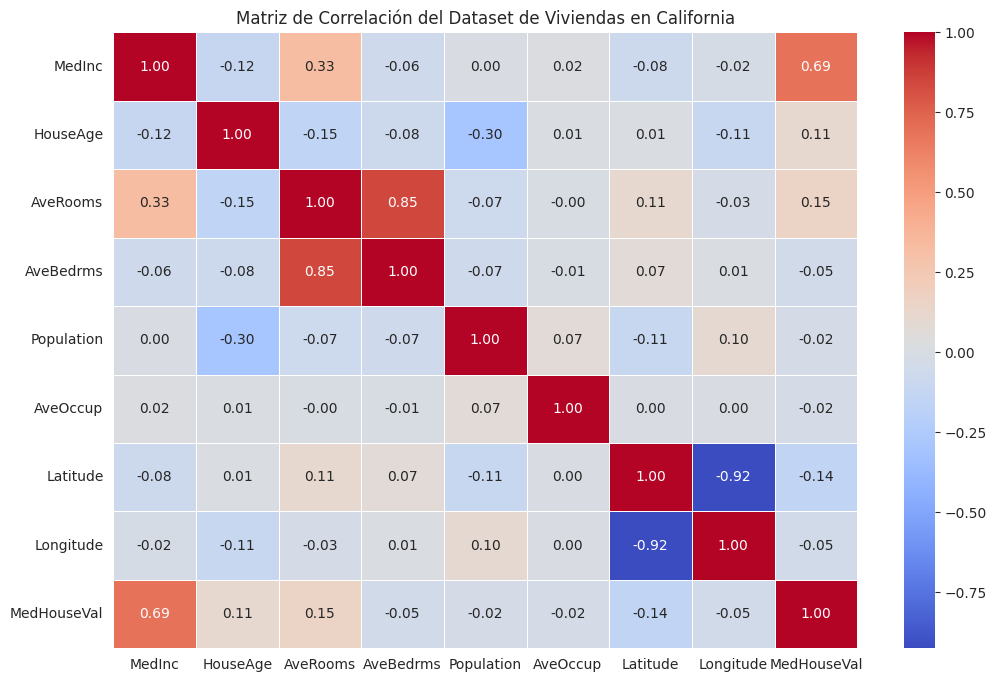

In [3]:
correlation_matrix = df_california.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación del Dataset de Viviendas en California")
plt.show()



### 1. MedHouseVal
El atributo que tiene mayor correlacion con el target es *MedInc*. Esto indica que a medida que aumenta el ingreso medio, tienden a aumentar las casas en ese bloque. El resto de los atributos, no posee una relacion fuerte con el taget.

### 2. Otros atributos



*   *AveBedrms* y *AveRooms* tienen una alta correlacion entre si, esto nos dice que que a medida que un bloque de casas tiene mas habitaciones, tambien tiene mas dormitorios.
*   *Latitude* y *Longitude* poseen una alta correlacion negativa.

En este sentido para eliminar la correlación entre las features podríamos eliminar 1 de cada par que tiene alta correlación entre sí (es decir, podría ser redundante para nuestro modelo).




# 2. Histogramas

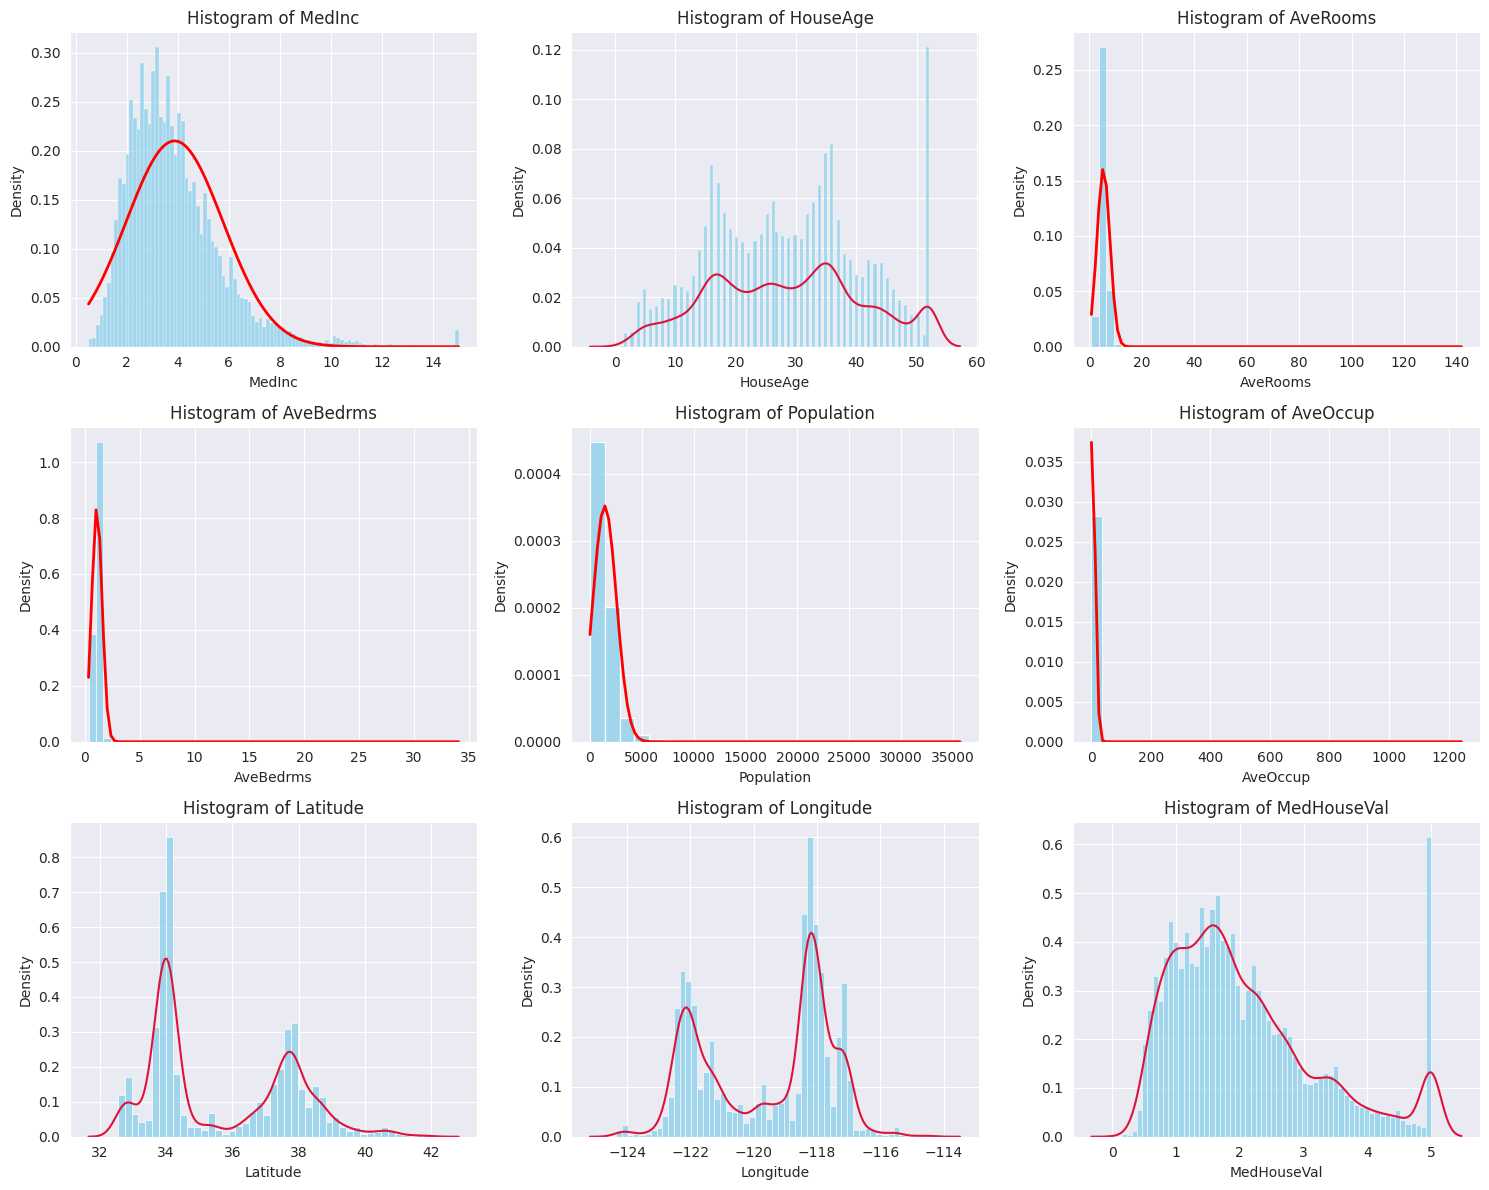

In [4]:
import numpy as np
from scipy.stats import norm
def plot_histogram(df):
    columns_to_plot = df.columns 
    # Define the number of bins for each plot
    bins_list = [100, 100, 50, 50, 25, 35, 45, 55, 60]  # Customize bins for each plot
    # plotting without outliers
    # x_lims = {
    #     'AveRooms': [0, 20],
    #     'AveBedrms': [0, 5],
    #     'Population': [0, 6],
    #     'AveOccup': [0,50]
    # } 
    
    kde_columns = ['HouseAge', 'Latitude' , 'Longitude', 'MedHouseVal'] # these must be estimated by kde
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten() 
    for i, col in enumerate(columns_to_plot):
        sns.histplot(df[col], stat='density', bins=bins_list[i], kde=False, ax=axes[i], color='skyblue')
        
        if col in kde_columns:
            sns.kdeplot(df[col], ax=axes[i], color='crimson')
        else:
            mean = df[col].mean()
            std = df[col].std()
            
            x = np.linspace(df[col].min(), df[col].max(), 100)
            y = norm.pdf(x, mean, std)
            axes[i].plot(x, y, color='red', lw=2)
        # if col in x_lims:
        #     axes[i].set_xlim(x_lims[col])        
        
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()
    
plot_histogram(df_california)

Por lo que se puede ver:
La mayoría se podría interpretar como suma de distribuciones gaussianas, en algunas es solo 1 o puede llegar a tratarse de la suma de 6 en el mismo gráfico (por ejemplo HouseAge).
Vemos que hay algunos gráficos que tienen un pico pronunciado.
En algunos casos como AveBedrms es porque hay valores que acumulan mucha densidad de probabilidad y no nos permiten observar algunos detalles en el histograma.

Puede haber datos que han sido mal introducidos ya sea por error de tipeo o del sistema.



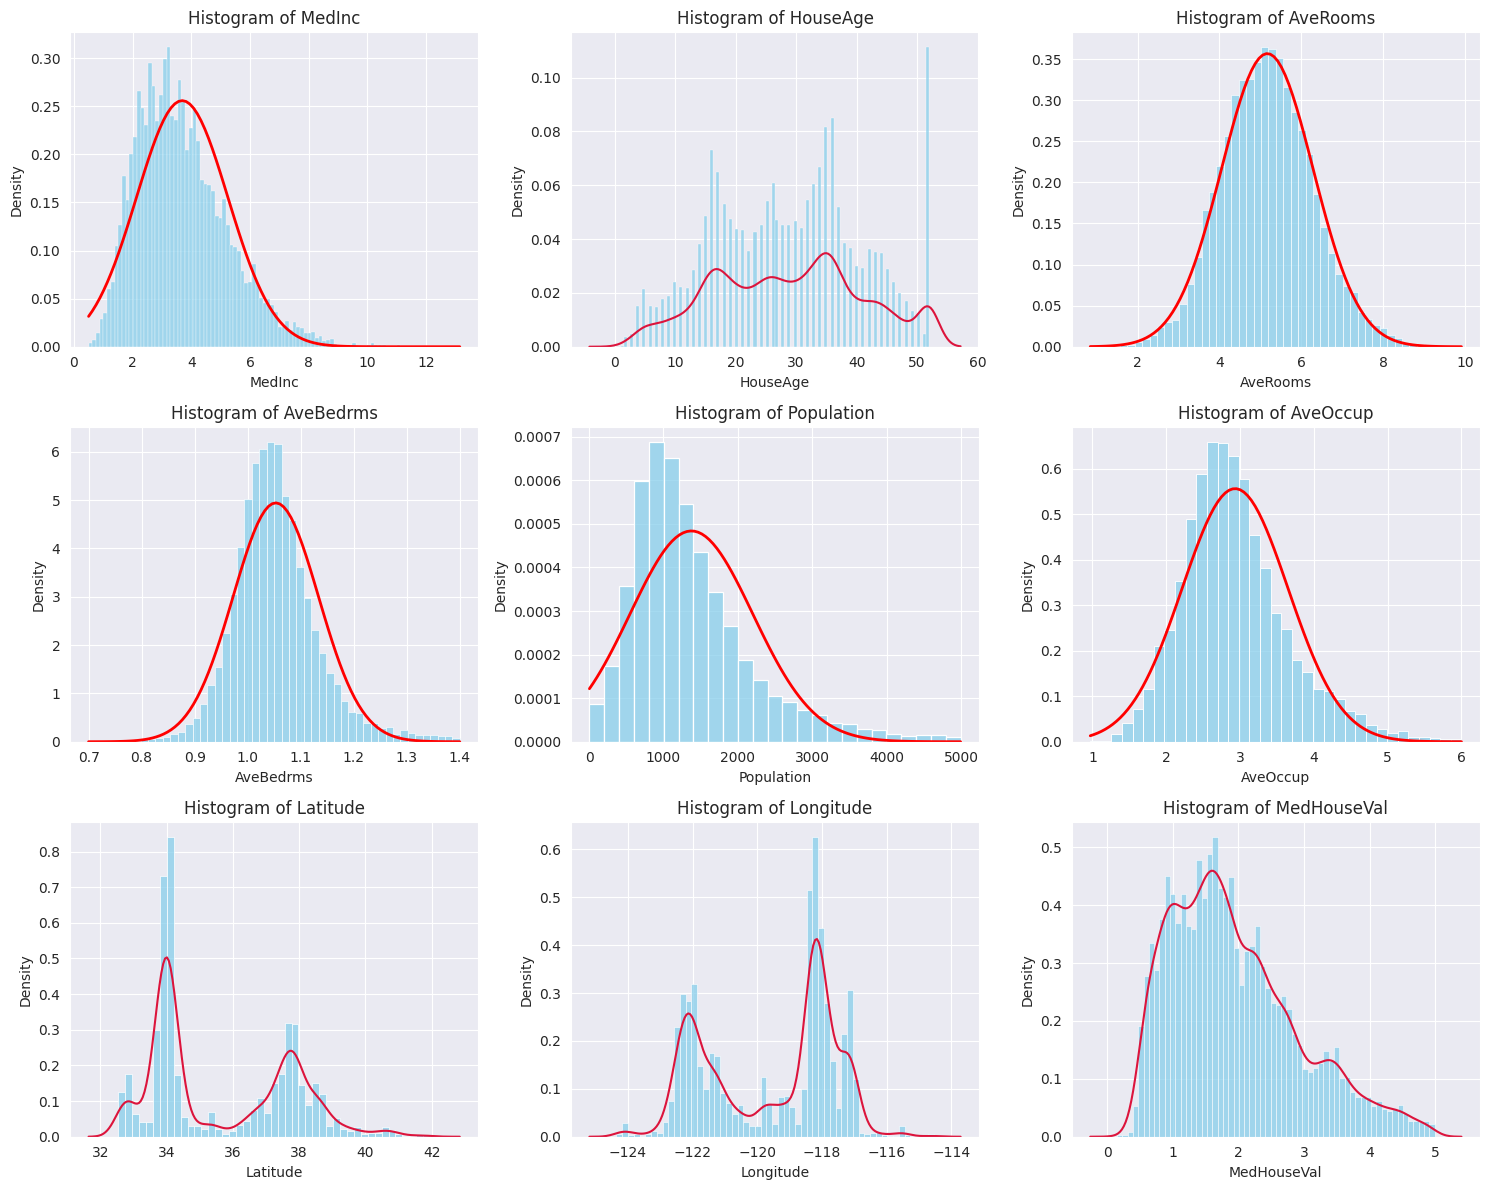

In [40]:
import numpy as np
from scipy.stats import norm
def plot_histogram(df):
    columns_to_plot = df.columns 
    # Define the number of bins for each plot
    bins_list = [100, 100, 50, 50, 25, 35, 45, 55, 60]  # Customize bins for each plot
    # plotting without outliers
    kde_columns = ['HouseAge', 'Latitude' , 'Longitude', 'MedHouseVal'] # these must be estimated by kde
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten() 
    for i, col in enumerate(columns_to_plot):        
        data = df[col]
        
        sns.histplot(data, stat='density', bins=bins_list[i], kde=False, ax=axes[i], color='skyblue')
        
        if col in kde_columns:
            sns.kdeplot(data, ax=axes[i], color='crimson')
        else:
            mean = data.mean()
            std = data.std()
            
            x = np.linspace(data.min(), data.max(), 100)
            y = norm.pdf(x, mean, std)
            axes[i].plot(x, y, color='red', lw=2)
        
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

def filter_outliers(df_to_filter):    
    new_df = df_to_filter.copy()
    new_df = new_df[(0 <= new_df["MedInc"]) & (new_df["MedInc"] <= 14)] 
    new_df = new_df[(0 <= new_df["AveRooms"]) & (new_df["AveRooms"] <= 10)] 
    new_df = new_df[(0.7 <= new_df["AveBedrms"]) & (new_df["AveBedrms"] <= 1.4)]
    new_df = new_df[(0 <= new_df["Population"]) & (new_df["Population"] <= 5000)]
    new_df = new_df[(0 <= new_df["AveOccup"]) & (new_df["AveOccup"] <= 6)]
    new_df = new_df[(0 <= new_df["MedHouseVal"]) & (new_df["MedHouseVal"] <= 4.99999999)]
    return new_df

california_data_wo_outliers = filter_outliers(df_california)
plot_histogram(filter_outliers(df_california))

# 3. Regresion Lineal

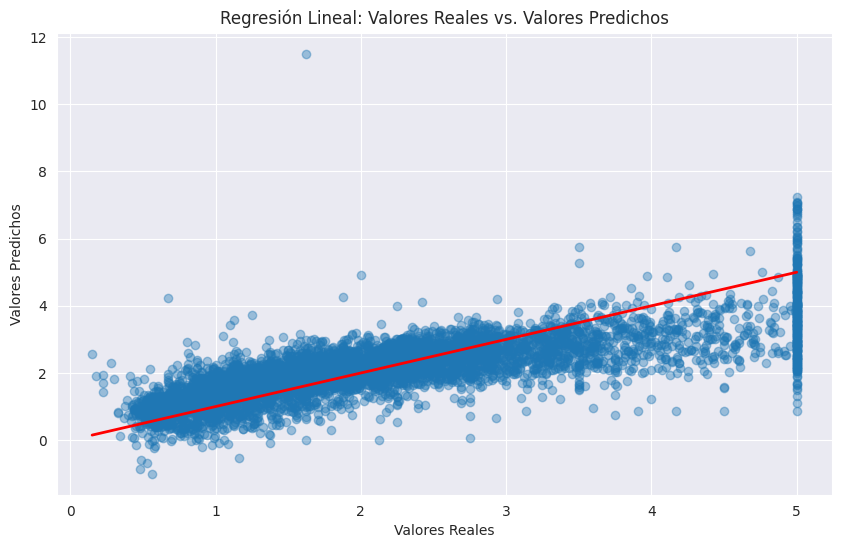

Varianza Total: 1.31, Varianza Explicada: 0.81
MSE: 0.5306
R2: 0.5958
MAE: 0.5272


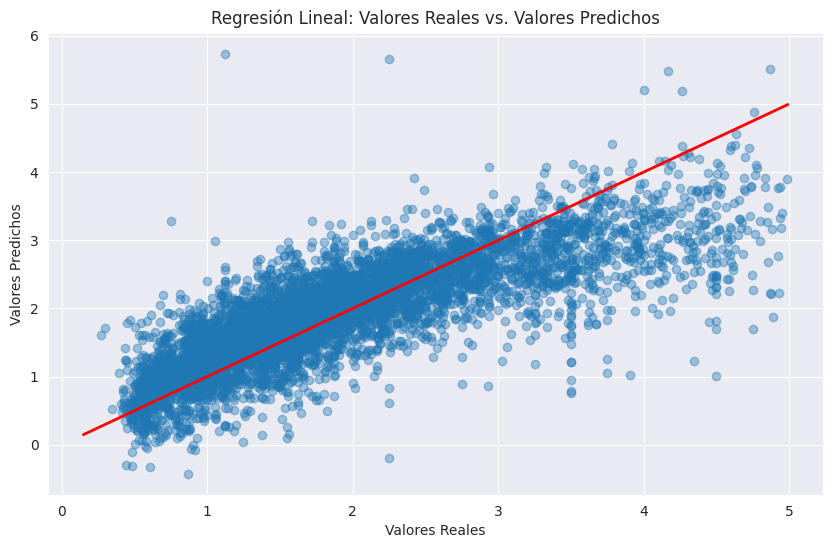

Varianza Total: 0.962, Varianza Explicada: 0.613
MSE: 0.3521
R2: 0.634
MAE: 0.4382


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error



def get_variance(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Entrenar el modelo de regresión lineal
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    # Predicciones en el conjunto de entrenamiento
    y_test_pred = lin_reg.predict(X_test)
    
    # Calcular varianza total y explicada
    total_variance = np.var(y_test)
    explained_variance = np.var(y_test_pred)

    # Graficar los valores reales vs. los valores predichos
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.4)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='r', lw=2)  # Línea ideal
    plt.xlabel("Valores Reales")
    plt.ylabel("Valores Predichos")
    plt.title("Regresión Lineal: Valores Reales vs. Valores Predichos")
    plt.grid(True)
    plt.show()
    print(f"Varianza Total: {total_variance:.3g}, Varianza Explicada: {explained_variance:.3g}")
    print('MSE:', f'{mean_squared_error(y_test, y_test_pred):.4g}')
    print('R2:', f'{r2_score(y_test, y_test_pred):.4g}')
    print('MAE:', f'{mean_absolute_error(y_test, y_test_pred):.4g}')

california_data = fetch_california_housing(as_frame=True)

class FilteredData:
    def __init__(self):
        filtered_data = filter_outliers(df_california)
        self.data = filtered_data[california_data.data.columns]
        self.target = filtered_data['MedHouseVal']
    
filtered_data = FilteredData()

get_variance(california_data.data, california_data.target)
get_variance(filtered_data.data, filtered_data.target)


El modelo esta capturando el comportamiento del target, pero con limitaciones. Aunque muchos puntos están relativamente cerca de la línea, hay una dispersion alta, especialmente en los valores más altos (cercanos a 5 en el eje X).

Esto puede deberse a que hay una relacion no lineal entre los atributos y el target o que puntos dispersos esten afectando al modelo.

## 4. MSE, MAE, R2 con conjunto de test

## 5.Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Cargar los datos de California Housing
california_data = fetch_california_housing(as_frame=True)

def normalize_dataframe(df):
    scaler = MinMaxScaler()
    normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return normalized_df

class NormalizedCaliforniaData:
    def __init__(self):
        scaler = MinMaxScaler()
        self.data = normalize_dataframe(california_data.data)
        self.target = scaler.fit_transform(california_data.target.values.reshape(-1, 1))
        
class NormalizedFilteredData:
    def __init__(self):
        scaler = MinMaxScaler()
        cd = FilteredData()
        self.data = normalize_dataframe(cd.data)
        self.target = scaler.fit_transform(cd.target.values.reshape(-1, 1))


def plot_mse_vs_alpha(dataframe):
    X, y = dataframe.data, dataframe.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Valores de alpha a probar
    alphas = np.linspace(0, 12.5, 100)
    
    # Guardar los MSE para cada alpha
    # mse_scores = []

    parameters = {'alpha': alphas}

    ridge_reg = GridSearchCV(Ridge(), parameters, scoring="neg_mean_squared_error", cv=5) 
    
    ridge_reg.fit(X_train, y_train)
    
    mse_scores = -ridge_reg.cv_results_["mean_test_score"] # it's negative MSE
    
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, mse_scores, marker='o')
    plt.title("MSE vs. Alpha para Ridge Regression")
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.show()



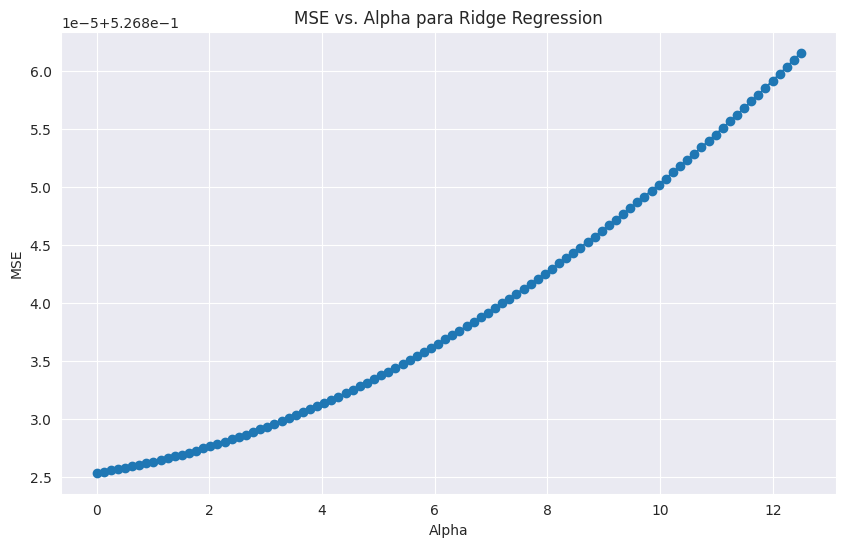

In [121]:
plot_mse_vs_alpha(california_data)

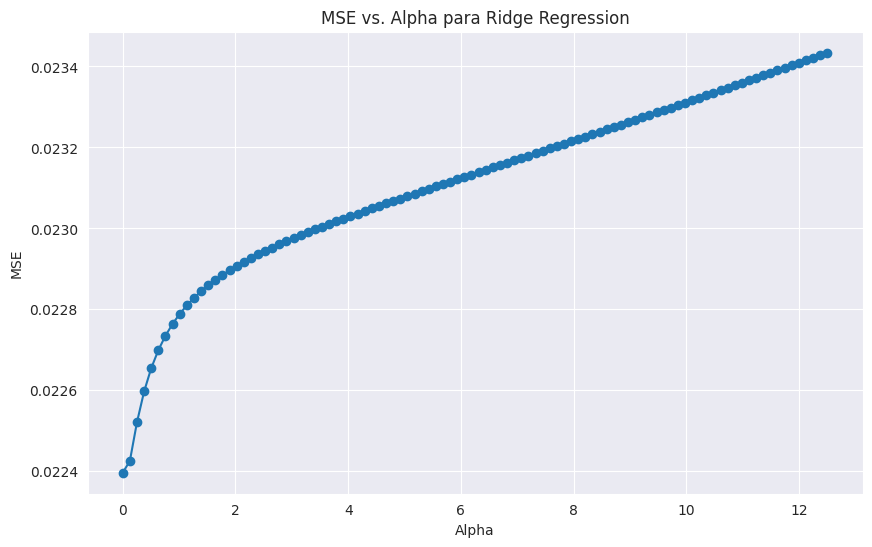

In [122]:
plot_mse_vs_alpha(NormalizedCaliforniaData())

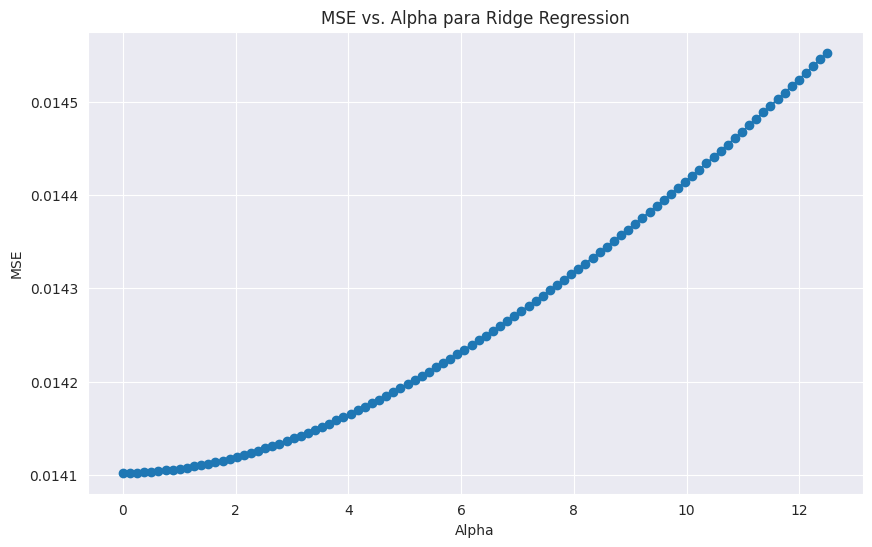

In [123]:
plot_mse_vs_alpha(NormalizedFilteredData())